## Data Acquistion

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [92]:
#Define image size for AlexNet
#It should be 256 since we are freezing maxpool layers
im_size = 128

In [93]:
#Define train set
data_dir = 'C:/Users/klab/Desktop/LSP_analyzed/data/'

In [94]:
#Transform the data: resize and crop it, normalize it with the AlexNet mean, sd
#and convert it to a tensor
data_transform = transforms.Compose([
        transforms.Resize(im_size),
        transforms.CenterCrop(im_size),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

In [95]:
#Initialize image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transform)
                  for x in ['train', 'val', 'test']}

print('Image datasets are:', image_datasets)

Image datasets are: {'train': Dataset ImageFolder
    Number of datapoints: 14000
    Root location: C:/Users/klab/Desktop/LSP_analyzed/data/train
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           ), 'val': Dataset ImageFolder
    Number of datapoints: 7000
    Root location: C:/Users/klab/Desktop/LSP_analyzed/data/val
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 7000
    Root location: C:/Users/klab/Desktop/LSP_analyzed/data/test
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=PIL.Image.BILINEAR)
       

In [96]:
#Combine the dataset. 
#Batch size is 4 images to load and shuffle images at every epoch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val', 'test']}

#What is the size of dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print('Size of the dataset is:', dataset_sizes)

#Classes of the dataset
class_names = image_datasets['train'].classes
print('Number of classes: ', len(class_names))
print('Class names are:', class_names)

#Device that we are running the code
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Size of the dataset is: {'train': 14000, 'val': 7000, 'test': 7000}
Number of classes:  14
Class names are: ['htop', 'lankle', 'lelbow', 'lhip', 'lknee', 'lshoulder', 'lwrist', 'neck', 'rankle', 'relbow', 'rhip', 'rknee', 'rshoulder', 'rwrist']
Running on device: cuda:0


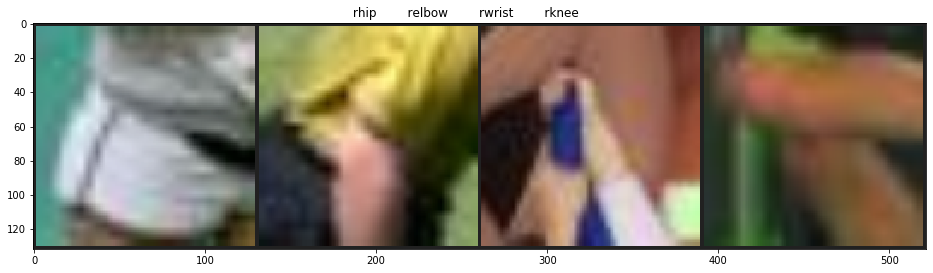

In [97]:
#Visualize some training images

#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#Normalize the batch
out = out.numpy().transpose((1, 2, 0))
mean = np.array(0.1307,)
std = np.array(0.3081, )
out = std * out + mean
out = np.clip(out, 0, 1)

#Plot
fig, ax = plt.subplots(1, 1, figsize = (16,6))
ax.set_title(''.join('%5s        ' %class_names[classes[j]] for j in range(4)))    
ax.imshow(out)

## Transfer Learning

### Training

In [98]:
#Get AlexNet model
model_conv = torchvision.models.alexnet(pretrained=True)
print(model_conv)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [99]:
#Freeze all layers except the last one
for param in model_conv.parameters():
    param.requires_grad = False 

In [100]:
# Number of features in the bottleneck layer
num_ftrs = model_conv.classifier[6].in_features

#Substitute it with a new fully connected layer with the same number of inputs but only 14 outputs
#Since this LSP dataset and different from the ImageNet, we are using a linear classifier
model_conv.classifier[6] = nn.Linear(num_ftrs, 14)

In [101]:
import torch.optim as optim

# define cross entropy loss
criterion = nn.CrossEntropyLoss()

# define the optimizer. Note that we tell the optimizer to only update the 
# parameters in the last layer. Also, remember that we have set requires_grad=False
# on all other parameters of the model, so the optimizer wouldn't have gradient
# information on them if we asked it to update all the parameters.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=1e-4, momentum=0.9)

In [102]:
#Define the device that you are running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

#Move your model to GPU
model_conv.to(device)

Running on device: cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [103]:
import time

# generic training function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [104]:
#Train the model

train_model(model_conv, criterion, optimizer_conv, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.1691 Acc: 0.2865
val Loss: 1.9069 Acc: 0.3407

Epoch 1/24
----------
train Loss: 1.9520 Acc: 0.3434
val Loss: 1.9236 Acc: 0.3570

Epoch 2/24
----------
train Loss: 1.8816 Acc: 0.3648
val Loss: 1.8606 Acc: 0.3660

Epoch 3/24
----------
train Loss: 1.8284 Acc: 0.3794
val Loss: 1.8491 Acc: 0.3617

Epoch 4/24
----------
train Loss: 1.7826 Acc: 0.3959
val Loss: 1.8691 Acc: 0.3661

Epoch 5/24
----------
train Loss: 1.7476 Acc: 0.4062
val Loss: 1.9603 Acc: 0.3557

Epoch 6/24
----------
train Loss: 1.7067 Acc: 0.4121
val Loss: 1.8323 Acc: 0.3764

Epoch 7/24
----------
train Loss: 1.6947 Acc: 0.4231
val Loss: 1.9972 Acc: 0.3459

Epoch 8/24
----------
train Loss: 1.6690 Acc: 0.4296
val Loss: 1.8480 Acc: 0.3703

Epoch 9/24
----------
train Loss: 1.6596 Acc: 0.4318
val Loss: 1.9358 Acc: 0.3623

Epoch 10/24
----------
train Loss: 1.6432 Acc: 0.4388
val Loss: 1.9003 Acc: 0.3663

Epoch 11/24
----------
train Loss: 1.6376 Acc: 0.4353
val Loss: 1.8506 Acc: 0.3700

Ep